# AI for finance - Project 2

## Part 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Preparing the data

In [2]:
y10 = pd.read_csv('GS10.csv')

y10

,DATE,GS10
0,1955-01-01,2.61
1,1955-02-01,2.65
2,1955-03-01,2.68
3,1955-04-01,2.75
4,1955-05-01,2.76
...,...,...
813,2022-10-01,3.98
814,2022-11-01,3.89
815,2022-12-01,3.62
816,2023-01-01,3.53


In [3]:
m3 = pd.read_csv('TB3MS.csv')
m3

,DATE,TB3MS
0,1955-01-01,1.22
1,1955-02-01,1.17
2,1955-03-01,1.28
3,1955-04-01,1.59
4,1955-05-01,1.45
...,...,...
813,2022-10-01,3.72
814,2022-11-01,4.15
815,2022-12-01,4.25
816,2023-01-01,4.54


In [4]:
nber = pd.read_csv('NBER.csv')
nber

,DATE,USREC
0,1955-01-01,0
1,1955-02-01,0
2,1955-03-01,0
3,1955-04-01,0
4,1955-05-01,0
...,...,...
813,2022-10-01,0
814,2022-11-01,0
815,2022-12-01,0
816,2023-01-01,0


In [5]:
data = pd.DataFrame()
data['Date'] = m3['DATE']
data['Term'] = y10['GS10'] - m3['TB3MS']
data.set_index('Date', inplace=True)
data

,Term
Date,
1955-01-01,1.39
1955-02-01,1.48
1955-03-01,1.40
1955-04-01,1.16
1955-05-01,1.31
...,...
2022-10-01,0.26
2022-11-01,-0.26
2022-12-01,-0.63


In [6]:
#transforming in quarterly data the Term values
data = data.groupby(pd.PeriodIndex(data.index, freq='Q'), axis=0).mean()
data

,Term
Date,
1955Q1,1.423333
1955Q2,1.280000
1955Q3,1.090000
1955Q4,0.573333
1956Q1,0.573333
...,...
2022Q1,1.633333
2022Q2,1.853333
2022Q3,0.443333


In [7]:
#transforming in quarterly data the recession values
nber.set_index('DATE', inplace=True)
nber = nber.groupby(pd.PeriodIndex(nber.index, freq='Q'), axis=0).max()
nber

,USREC
DATE,
1955Q1,0
1955Q2,0
1955Q3,0
1955Q4,0
1956Q1,0
...,...
2022Q1,0
2022Q2,0
2022Q3,0


In [8]:
#showing the dataset in quarterly time periods
data['Rec'] = nber['USREC']
data

,Term,Rec
Date,,
1955Q1,1.423333,0
1955Q2,1.280000,0
1955Q3,1.090000,0
1955Q4,0.573333,0
1956Q1,0.573333,0
...,...,...
2022Q1,1.633333,0
2022Q2,1.853333,0
2022Q3,0.443333,0


<AxesSubplot:xlabel='Date'>

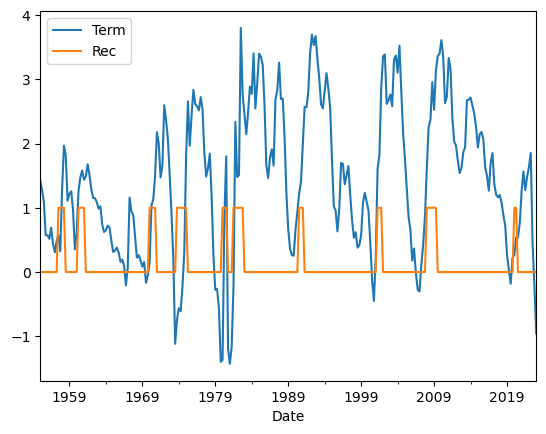

In [9]:
#plotting the Term spread curve along with the recessions values
data.plot()

### Probit model

In [10]:
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,r2_score

#setting lags
lag_periods = range(1,13)

number of LAGS:  1
R-squared 0.051222349697585656
ROC score:  0.7357859531772575


number of LAGS:  2
R-squared 0.14786032369854785
ROC score:  0.8366596638655461


number of LAGS:  3
R-squared 0.18842213712667055
ROC score:  0.9520255863539445


number of LAGS:  4
R-squared 0.23353236047937154
ROC score:  0.9014084507042253


number of LAGS:  5
R-squared 0.21935216125595458
ROC score:  0.8710021321961621


number of LAGS:  6
R-squared 0.18420665465381647
ROC score:  0.808450704225352


number of LAGS:  7
R-squared 0.10987333422619905
ROC score:  0.7417840375586855


number of LAGS:  8
R-squared 0.10045762688768711
ROC score:  0.5766823161189358


number of LAGS:  9
R-squared 0.06110911931261276
ROC score:  0.5514285714285714


number of LAGS:  10
R-squared 0.05278005730041624
ROC score:  0.5821678321678322


number of LAGS:  11
R-squared 0.03254398333245068
ROC score:  0.5904761904761905


number of LAGS:  12
R-squared 0.02368767478559719
ROC score:  0.5441542288557214




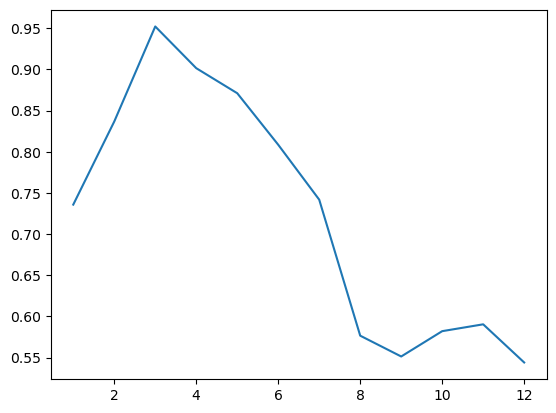

In [11]:
curve_values_probit = []
for lag in lag_periods:
    X = data['Term'][:-lag]
    y = data['Rec'].shift(-lag).dropna()

    X_train,X_test,Y_train,Y_test = train_test_split(X,y,train_size=0.7,random_state=42);
    
    X_sm_train = sm.add_constant(X_train)
    X_sm_test = sm.add_constant(X_test)

    model = Probit(Y_train, X_sm_train.astype(float))
    results = model.fit(disp=False)

    ypred = results.predict(X_sm_test.astype(float))
    fp, tp, threshold = roc_curve(Y_test, ypred)
    curve_values_probit.append(auc(fp,tp))
    
    print('number of LAGS: ', lag)
    print('R-squared', results.prsquared)
    print('ROC score: ', auc(fp,tp))
    print('\n')
    
plt.plot(lag_periods, curve_values_probit)

### Probabilistic Neural Network (PNN) model

In [12]:
#implementing the pnn using a gaussian distribution
gaussian = lambda x,b: (1.0/np.sqrt(2*np.pi))* np.exp(-.5*(x/b)**2)

def pattern_layer(inp,sigma):
  k_values=[];
  for i,p in enumerate(X_train.values):
    edis = np.linalg.norm(p-inp); #find eucliden distance
    k = gaussian(edis,sigma); #pass values of euclidean dist and 
    #smoothing parameter to kernel function
    k_values.append(k);
  return k_values;

def summation_layer(k_values,Y_train,class_counts):
  # Summing up each value for each class and then averaging
  summed =[0,0];
  for i,c in enumerate(class_counts):
    val = (Y_train==class_counts.index[i]).values;
    k_values = np.array(k_values);
    summed[i] = np.sum(k_values[val]);
    

  avg_sum = list(summed/class_counts);
  return avg_sum

def output_layer(avg_sum,class_counts):
  maxv = max(avg_sum);
  label = class_counts.index[avg_sum.index(maxv)];

  return label

def pnn(X_train,Y_train,X_test,sigma):
  # Initialising variables
  class_counts = Y_train.value_counts()
  labels=[];
  #Passing each sample observation
  for s in X_test.values:
    k_values = pattern_layer(s,sigma);
    avg_sum = summation_layer(k_values,Y_train,class_counts);
    label = output_layer(avg_sum,class_counts);
    labels.append(label);
  return labels;

number of LAGS:  1
sigma: 1.0
R-squared -0.7369007803790415
ROC score:  0.6750278706800446


number of LAGS:  2
sigma: 1.0
R-squared -0.4642857142857144
ROC score:  0.7615546218487396


number of LAGS:  3
sigma: 1.0
R-squared -0.036247334754797356
ROC score:  0.8821961620469083


number of LAGS:  4
sigma: 1.0
R-squared -1.167605633802817
ROC score:  0.8661971830985915


number of LAGS:  5
sigma: 1.0
R-squared -0.8134328358208958
ROC score:  0.8150319829424308


number of LAGS:  6
sigma: 1.0
R-squared -1.2816901408450705
ROC score:  0.8161971830985915


number of LAGS:  7
sigma: 1.0
R-squared -2.7558685446009386
ROC score:  0.7402190923317683


number of LAGS:  8
sigma: 1.0
R-squared -4.007824726134585
ROC score:  0.621283255086072


number of LAGS:  9
sigma: 1.0
R-squared -3.9142857142857146
ROC score:  0.65


number of LAGS:  10
sigma: 1.0
R-squared -3.3275058275058296
ROC score:  0.5821678321678322


number of LAGS:  11
sigma: 1.0
R-squared -4.642857142857142
ROC score:  0.5817460317

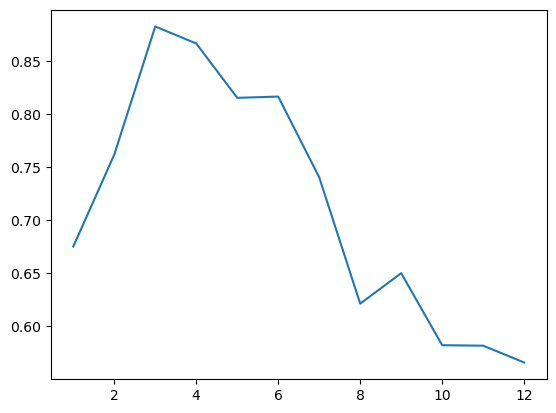

In [13]:
curve_values_pnn = []
sigma = 1.0
for lag in lag_periods:
    X = data['Term'][:-lag]
    y = data['Rec'].shift(-lag).dropna()

    X_train,X_test,Y_train,Y_test = train_test_split(X,y,train_size=0.7,random_state=42);


    pred = pnn(X_train,Y_train,X_test,sigma);
    
    #accuracy = accuracy_score(Y_test.values,pred);
    #f1= f1_score(Y_test.values,pred,average='weighted')
    #print('accuracy:',accuracy)
    #print('f1-score:',f1)
    rsquared = r2_score(Y_test, pred, multioutput=None)
    fp, tp, threshold = roc_curve(Y_test, pred)
    curve_values_pnn.append(auc(fp,tp))
    print('number of LAGS: ', lag)
    print('sigma:',sigma);
    print('R-squared', rsquared)
    print('ROC score: ', auc(fp,tp))
    print('\n')
    
plt.plot(lag_periods, curve_values_pnn)

### Multi-layer Perceptron (MLP) model

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

number of LAGS:  1
R-squared:  -0.0969899665551841
ROC score:  0.5696767001114826


number of LAGS:  2
R-squared:  -0.03361344537815136
ROC score:  0.6281512605042016


number of LAGS:  3
R-squared:  0.13646055437100213
ROC score:  0.6711087420042644


number of LAGS:  4
R-squared:  -0.026760563380281654
ROC score:  0.6788732394366197


number of LAGS:  5
R-squared:  -0.03624733475479758
ROC score:  0.6279317697228145


number of LAGS:  6
R-squared:  -0.25492957746478884
ROC score:  0.5359154929577465


number of LAGS:  7
R-squared:  -0.0015649452269168584
ROC score:  0.5555555555555556


number of LAGS:  8
R-squared:  -0.6275430359937402
ROC score:  0.47183098591549294


number of LAGS:  9
R-squared:  -0.1428571428571428
ROC score:  0.5


number of LAGS:  10
R-squared:  -0.19696969696969746
ROC score:  0.5


number of LAGS:  11
R-squared:  -0.25396825396825395
ROC score:  0.4928571428571429


number of LAGS:  12
R-squared:  -0.17910447761193993
ROC score:  0.5




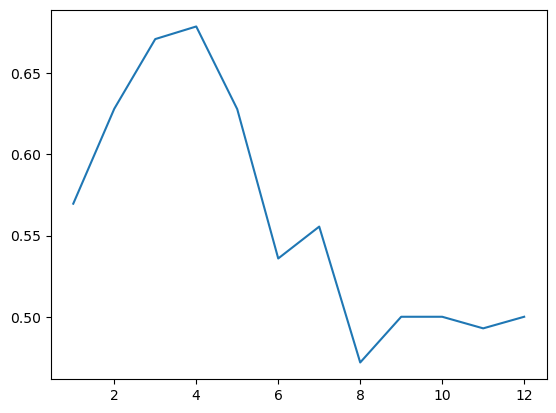

In [15]:
curve_values_mlp = []

for lag in lag_periods:
    X = data['Term'][:-lag].array.reshape(-1,1)
    y = data['Rec'].shift(-lag).dropna()

    X_train,X_test,Y_train,Y_test = train_test_split(X,y,train_size=0.7,random_state=42);

    clf = MLPClassifier(hidden_layer_sizes=(7,3,3),verbose=False,learning_rate_init=0.01,activation='tanh')

    clf.fit(X_train,Y_train)
    ypred=clf.predict(X_test)
    
    fp, tp, threshold = roc_curve(Y_test, ypred)
    curve_values_mlp.append(auc(fp,tp))
    
    print('number of LAGS: ', lag)
    print('R-squared: ',r2_score(Y_test, ypred, multioutput=None))
    print('ROC score: ', auc(fp,tp))
    print('\n')
    
plt.plot(lag_periods, curve_values_mlp)

### Comparing models' results

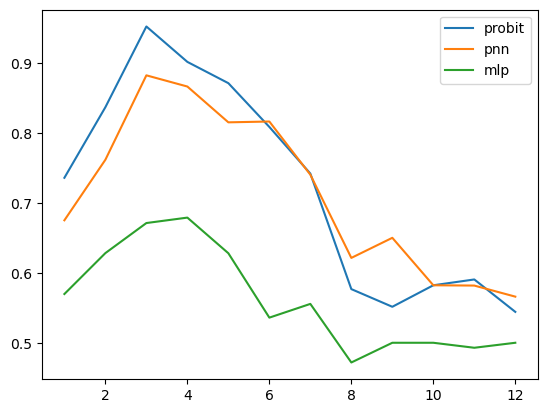

In [16]:
plt.plot(lag_periods, curve_values_probit, label='probit')
plt.plot(lag_periods, curve_values_pnn, label='pnn')
plt.plot(lag_periods, curve_values_mlp, label='mlp')

plt.legend(loc='best')
plt.show()

## Part 2

### Probit vs PNN vs MLP

number of LAGS:  1
R-squared 0.5137528344891453
ROC score:  0.9643255295429207


number of LAGS:  2
R-squared 0.34577488440231474
ROC score:  0.930672268907563


number of LAGS:  3
R-squared 0.24070597699893537
ROC score:  0.9221748400852878


number of LAGS:  4
R-squared 0.24642030418430805
ROC score:  0.8690140845070422


number of LAGS:  5
R-squared 0.22000133693709178
ROC score:  0.8763326226012793


number of LAGS:  6
R-squared 0.19608895418495575
ROC score:  0.8225352112676056


number of LAGS:  7
R-squared 0.11654285394816455
ROC score:  0.7699530516431925


number of LAGS:  8
R-squared 0.10461883397585514
ROC score:  0.5876369327073552


number of LAGS:  9
R-squared 0.061423826870949494
ROC score:  0.5557142857142857


number of LAGS:  10
R-squared 0.052800060364000645
ROC score:  0.5775058275058276


number of LAGS:  11
R-squared 0.03336170832653085
ROC score:  0.6031746031746031


number of LAGS:  12
R-squared 0.02589682178573527
ROC score:  0.5677860696517413




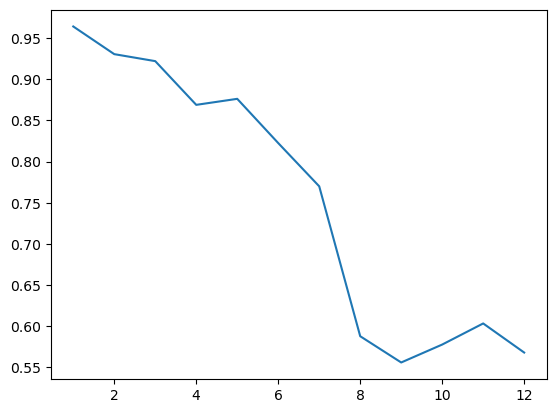

In [17]:
curve_values_probit = []
for lag in lag_periods:
    X = data[:-lag]
    y = data['Rec'].shift(-lag).dropna()

    X_train,X_test,Y_train,Y_test = train_test_split(X,y,train_size=0.7,random_state=42);
    
    X_sm_train = sm.add_constant(X_train)
    X_sm_test = sm.add_constant(X_test)

    model = Probit(Y_train, X_sm_train.astype(float))
    results = model.fit(disp=False)

    ypred = results.predict(X_sm_test.astype(float))
    fp, tp, threshold = roc_curve(Y_test, ypred)
    curve_values_probit.append(auc(fp,tp))
    
    print('number of LAGS: ', lag)
    print('R-squared', results.prsquared)
    print('ROC score: ', auc(fp,tp))
    print('\n')
    
plt.plot(lag_periods, curve_values_probit)

number of LAGS:  1
sigma: 1.0
R-squared 0.26867335562987726
ROC score:  0.8795986622073579


number of LAGS:  2
sigma: 1.0
R-squared -0.2058823529411764
ROC score:  0.8119747899159664


number of LAGS:  3
sigma: 1.0
R-squared -0.036247334754797356
ROC score:  0.8821961620469083


number of LAGS:  4
sigma: 1.0
R-squared -1.167605633802817
ROC score:  0.8661971830985915


number of LAGS:  5
sigma: 1.0
R-squared -0.8134328358208958
ROC score:  0.8150319829424308


number of LAGS:  6
sigma: 1.0
R-squared -1.2816901408450705
ROC score:  0.8591549295774648


number of LAGS:  7
sigma: 1.0
R-squared -2.881064162754303
ROC score:  0.7331768388106417


number of LAGS:  8
sigma: 1.0
R-squared -3.88262910798122
ROC score:  0.6283255086071987


number of LAGS:  9
sigma: 1.0
R-squared -3.9142857142857146
ROC score:  0.65


number of LAGS:  10
sigma: 1.0
R-squared -3.419580419580421
ROC score:  0.5745920745920745


number of LAGS:  11
sigma: 1.0
R-squared -4.5174603174603165
ROC score:  0.58888888888

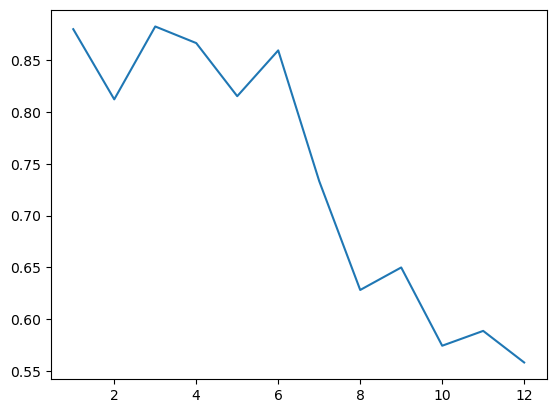

In [18]:
curve_values_pnn = []
sigma = 1.0
for lag in lag_periods:
    X = data[:-lag]
    y = data['Rec'].shift(-lag).dropna()

    X_train,X_test,Y_train,Y_test = train_test_split(X,y,train_size=0.7,random_state=42);


    pred = pnn(X_train,Y_train,X_test,sigma);
    
    rsquared = r2_score(Y_test, pred, multioutput=None)
    fp, tp, threshold = roc_curve(Y_test, pred)
    curve_values_pnn.append(auc(fp,tp))
    print('number of LAGS: ', lag)
    print('sigma:',sigma);
    print('R-squared', rsquared)
    print('ROC score: ', auc(fp,tp))
    print('\n')
    
plt.plot(lag_periods, curve_values_pnn)

number of LAGS:  1
R-squared:  0.45150501672240795
ROC score:  0.862876254180602


number of LAGS:  2
R-squared:  0.05252100840336127
ROC score:  0.6638655462184874


number of LAGS:  3
R-squared:  -0.036247334754797356
ROC score:  0.5996801705756929


number of LAGS:  4
R-squared:  -0.026760563380281654
ROC score:  0.6788732394366197


number of LAGS:  5
R-squared:  -0.03624733475479758
ROC score:  0.5996801705756929


number of LAGS:  6
R-squared:  -0.25492957746478884
ROC score:  0.5359154929577465


number of LAGS:  7
R-squared:  -0.0015649452269168584
ROC score:  0.5555555555555556




C:\Users\giova\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


number of LAGS:  8
R-squared:  -0.2519561815336462
ROC score:  0.49295774647887325


number of LAGS:  9
R-squared:  -0.1428571428571428
ROC score:  0.5


number of LAGS:  10
R-squared:  -0.28904428904428947
ROC score:  0.49242424242424243


number of LAGS:  11
R-squared:  -0.25396825396825395
ROC score:  0.4928571428571429


number of LAGS:  12
R-squared:  -0.17910447761193993
ROC score:  0.5




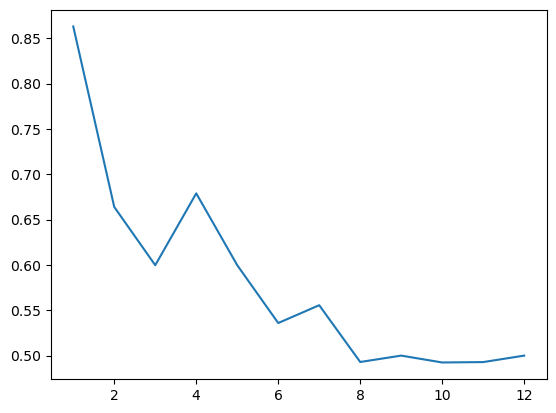

In [19]:
curve_values_mlp = []

for lag in lag_periods:
    X = data[:-lag]
    y = data['Rec'].shift(-lag).dropna()

    X_train,X_test,Y_train,Y_test = train_test_split(X,y,train_size=0.7,random_state=42);

    clf = MLPClassifier(hidden_layer_sizes=(7,3,3),verbose=False,learning_rate_init=0.01,activation='tanh')

    clf.fit(X_train,Y_train)
    ypred=clf.predict(X_test)
    
    fp, tp, threshold = roc_curve(Y_test, ypred)
    curve_values_mlp.append(auc(fp,tp))
    
    print('number of LAGS: ', lag)
    print('R-squared: ',r2_score(Y_test, ypred, multioutput=None))
    print('ROC score: ', auc(fp,tp))
    print('\n')
    
plt.plot(lag_periods, curve_values_mlp)

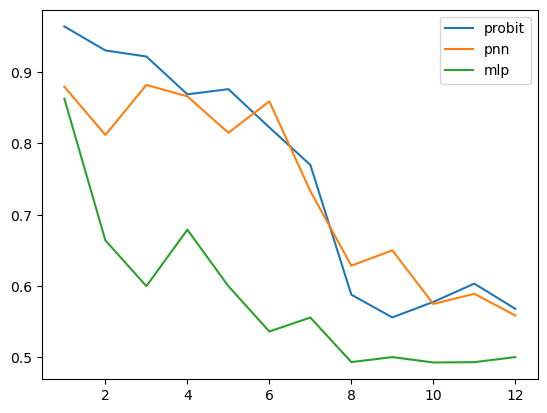

In [20]:
plt.plot(lag_periods, curve_values_probit, label='probit')
plt.plot(lag_periods, curve_values_pnn, label='pnn')
plt.plot(lag_periods, curve_values_mlp, label='mlp')

plt.legend(loc='best')
plt.show()